<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/LLM_Court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [396]:
import matplotlib.pyplot as plt
import torch
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import time
import re
import openai
import json
from sklearn.model_selection import train_test_split
import ast
from google.colab import userdata

In [397]:
def fix_hebrew_labels(ax):
    """ Reverse Hebrew labels in Matplotlib plots. """
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        text = label.get_text()
        if any("\u0590" <= char <= "\u05FF" for char in text):  # Detect Hebrew characters
            label.set_text(text[::-1])
    ax.figure.canvas.draw()


In [398]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [399]:

folder_id = "בית המשפט - קבצים שנבדקו"
directory_path = f"/content/drive/My Drive/{folder_id}"
classifiers_path = "/content/drive/MyDrive/בית המשפט - מסווגים/"

if not os.path.exists(directory_path):
    print(f"Directory {directory_path} does not exist. Please check the folder path.")
else:
    dataframes = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            file_path = os.path.join(directory_path, file_name)
            try:
                df = pd.read_excel(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"Failed to read {file_name}: {e}")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print("All Excel files have been concatenated successfully!")

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


All Excel files have been concatenated successfully!


In [400]:
full_ra_rap = pd.read_excel("/content/drive/My Drive/full_ra_rap.xlsx")

In [401]:
check_gender_bias = pd.concat([dataframes[0], dataframes[1], dataframes[2]])
check_gender_bias = pd.merge(full_ra_rap, check_gender_bias, on='מספר הליך', how='left')
check_gender_bias.drop_duplicates(subset = 'מספר הליך',inplace = True)
check_gender_bias.dropna(subset = ["בקשה לרשות ערעור התקבלה?"],inplace=True)

In [402]:
for col in check_gender_bias.columns:
    if(col.find("מגדר")!=-1 or col.find("ערעור")!=-1 or col.find("מספר ")!=-1):
      print(col)

מספר תיק
מספר החלטות בתיק
מספר הליך
מספר גורמים שיפוטיים במותב
מגדר
מספר מילים בגוף המסמך
מספר עמודים
מספר צדדים בתיק
מספר תיקי דלמטה בתיק
מספר דיונים בתיק
מספר אירועים בתיק
מספר אישורי מסירה בתיק
מספר בקשות בתיק
מספר צד
מספר הבקשה
מספר תיק דלמטה מלא
מספר תיק דלמטה
מספר תיק מלא
מספר השופטים
בקשה לרשות ערעור התקבלה?
הערעור התקבל?
הערות תוצאת ערעור
prediction_adjusted_threshold
בקשת רשות ערעור התקבלה?
prediction_second_model_adjusted
ערעור התקבל?


In [403]:
check_gender_bias = check_gender_bias[["מספר הליך","מספר השופטים","בקשה לרשות ערעור התקבלה?","מגדר"]]

In [404]:
check_gender_bias[["בקשה לרשות ערעור התקבלה?","מגדר"]]

בקשה לרשות ערעור התקבלה?                     מגדר
495                       נדחה                  ['זכר']
503                       נדחה                  ['זכר']
537                       נדחה                  ['זכר']
539                        אחר                  ['זכר']
550                       נדחה                  ['זכר']
...                        ...                      ...
20482                     נדחה                  ['זכר']
20499                    התקבל  ['זכר', 'נקבה', 'נקבה']
20503                    התקבל   ['זכר', 'נקבה', 'זכר']
20540                      אחר                 ['נקבה']
20560                    התקבל    ['זכר', 'זכר', 'זכר']

[702 rows x 2 columns]

<ipython-input-405-533c6d08d180>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_gender_bias["מגדר"] = check_gender_bias["מגדר"].apply(literal_eval)  # ממיר טקסט לרשימה


<Figure size 800x500 with 0 Axes>

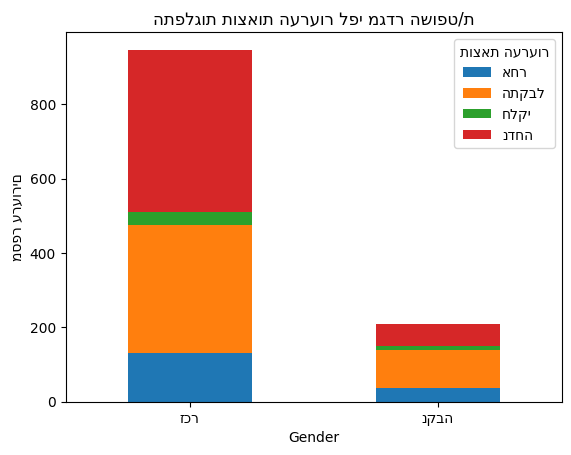

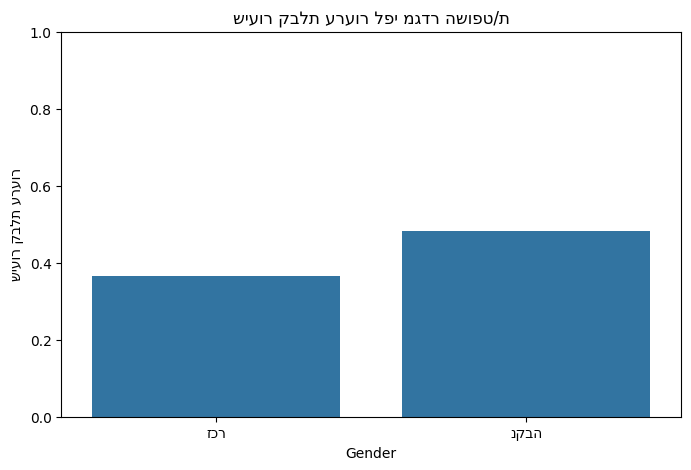

Appeal Outcome  אחר  התקבל  חלקי  נדחה  Total  Acceptance Rate
Gender                                                        
זכר             130    346    34   437    947         0.365364
נקבה             38    101    11    59    209         0.483254


In [405]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval


# המרת המחרוזת ברשימת מגדרים למבנה רשימה
check_gender_bias["מגדר"] = check_gender_bias["מגדר"].apply(literal_eval)  # ממיר טקסט לרשימה

# פונקציה להשטחת הנתונים – כל שופט יקבל שורה משלו
def expand_genders(df):
    expanded_data = []
    for _, row in df.iterrows():
        for gender in row["מגדר"]:
            expanded_data.append({"Gender": gender, "Appeal Outcome": row["בקשה לרשות ערעור התקבלה?"]})
    return pd.DataFrame(expanded_data)

# הרחבת הטבלה
df_expanded = expand_genders(check_gender_bias)

# ספירת תוצאות הערעור לפי מגדר
outcome_counts = df_expanded.groupby(["Gender", "Appeal Outcome"]).size().unstack().fillna(0)

# יצירת גרף התפלגות תוצאות לפי מגדר
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("מספר ערעורים")
plt.title("התפלגות תוצאות הערעור לפי מגדר השופט/ת")
plt.xticks(rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב יחס קבלת ערעור לכל מגדר
outcome_counts["Total"] = outcome_counts.sum(axis=1)
outcome_counts["Acceptance Rate"] = outcome_counts.get("התקבל", 0) / outcome_counts["Total"]

# יצירת גרף של אחוזי קבלת ערעור לפי מגדר
plt.figure(figsize=(8, 5))
sns.barplot(x=outcome_counts.index, y=outcome_counts["Acceptance Rate"])
plt.ylabel("שיעור קבלת ערעור")
plt.title("שיעור קבלת ערעור לפי מגדר השופט/ת")
plt.ylim(0, 1)
plt.show()

# הצגת הטבלה עם התוצאות
print(outcome_counts)


# Bias - number of Judges

<Figure size 800x500 with 0 Axes>

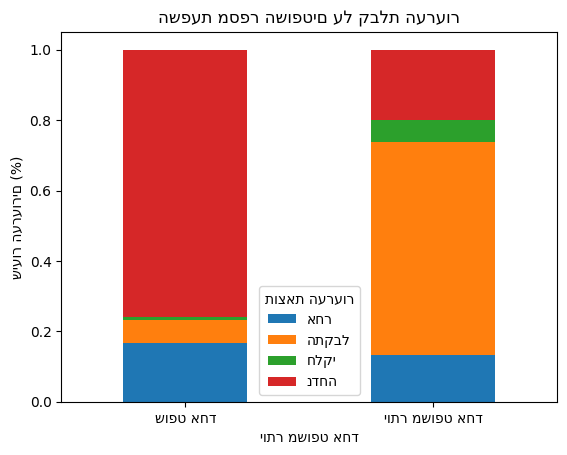

שיעור קבלת הערעור לפי מספר שופטים:
יותר משופט אחד
False    0.065126
True     0.606195
Name: התקבל, dtype: float64


In [406]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# טעינת הנתונים
df = check_gender_bias.copy()

# חישוב מספר השופטים בכל תיק
df["מספר שופטים"] = df["מגדר"].apply(len)

# חלוקת המקרים לשתי קבוצות: שופט יחיד או יותר מאחד
df["יותר משופט אחד"] = df["מספר שופטים"] > 1

# ספירת המקרים לפי מספר השופטים והאם הערעור התקבל
outcome_counts = df.groupby("יותר משופט אחד")["בקשה לרשות ערעור התקבלה?"].value_counts(normalize=True).unstack()

# יצירת גרף
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("שיעור הערעורים (%)")
plt.title("השפעת מספר השופטים על קבלת הערעור")
plt.xticks([0, 1], ["שופט אחד", "יותר משופט אחד"], rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב אחוז קבלת ערעור לפי מספר השופטים
acceptance_rate = outcome_counts.get("התקבל", 0)

# הדפסת סטטיסטיקה
print("שיעור קבלת הערעור לפי מספר שופטים:")
print(acceptance_rate)


<ipython-input-407-9995a47b4688>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_by_judges.index, y=grouped_by_judges.values, palette="Blues_r")


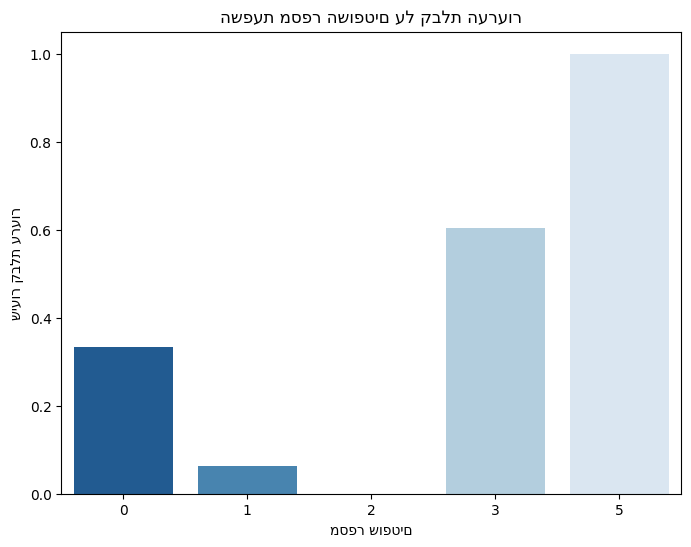

ערעור התקבל      0      1
מספר שופטים              
0              2.0    1.0
1            443.0   30.0
2              1.0    NaN
3             88.0  134.0
5              NaN    3.0
Chi-Square Test: p-value = 0.0000
מסקנה: קיים קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.
טבלת שכיחות לפי נוכחות שופטות:
 ערעור התקבל    0   1
מכיל נקבה           
False        433  87
True         101  81


<ipython-input-407-9995a47b4688>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_bias_table.index, y=gender_bias_table[1] / (gender_bias_table[1] + gender_bias_table[0]), palette="Reds_r")


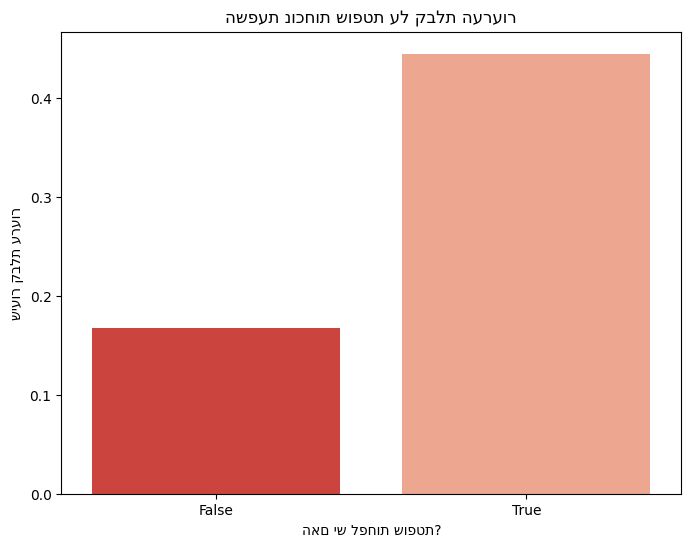

Chi-Square Test for Gender Bias: p-value = 0.0000
מסקנה: יש עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.


In [407]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

df = check_gender_bias.copy()

# לוודא שהעמודה 'מגדר' היא רשימה ולא מחרוזת
df["מגדר"] = df["מגדר"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# הוספת עמודת מספר השופטים בכל מקרה
df["מספר שופטים"] = df["מגדר"].apply(len)

# יצירת עמודת אינדיקטור אם הערעור התקבל או לא
df["ערעור התקבל"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: 1 if x == "התקבל" else 0)

### בדיקת הקשר בין מספר השופטים להחלטה ###
grouped_by_judges = df.groupby("מספר שופטים")["ערעור התקבל"].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=grouped_by_judges.index, y=grouped_by_judges.values, palette="Blues_r")
plt.xlabel("מספר שופטים")
plt.ylabel("שיעור קבלת ערעור")
plt.title("השפעת מספר השופטים על קבלת הערעור")
plt.show()

# טבלת שכיחות
judge_count_table = df.groupby("מספר שופטים")["ערעור התקבל"].value_counts().unstack()
print(judge_count_table)

# בדיקה סטטיסטית - האם יש קשר מובהק בין מספר שופטים להחלטה
chi2, p, _, _ = chi2_contingency(judge_count_table.fillna(0))
print(f"Chi-Square Test: p-value = {p:.4f}")
if p < 0.05:
    print("מסקנה: קיים קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.")
else:
    print("מסקנה: אין קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.")

### בדיקת ביאס מגדרי ###
# חישוב אחוז קבלת ערעור לפי מגדר
def get_gender_stats(gender_list, outcome):
    return any(g in gender_list for g in outcome)

df["מכיל זכר"] = df["מגדר"].apply(lambda x: "זכר" in x)
df["מכיל נקבה"] = df["מגדר"].apply(lambda x: "נקבה" in x)

# בדיקת הבדל בין מקרים עם לפחות שופטת לבין אלו ללא
gender_bias_table = df.groupby("מכיל נקבה")["ערעור התקבל"].value_counts().unstack()
print("טבלת שכיחות לפי נוכחות שופטות:\n", gender_bias_table)

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_bias_table.index, y=gender_bias_table[1] / (gender_bias_table[1] + gender_bias_table[0]), palette="Reds_r")
plt.xlabel("האם יש לפחות שופטת?")
plt.ylabel("שיעור קבלת ערעור")
plt.title("השפעת נוכחות שופטת על קבלת הערעור")
plt.show()

# בדיקה סטטיסטית - האם יש הבדל מובהק
chi2, p, _, _ = chi2_contingency(gender_bias_table.fillna(0))
print(f"Chi-Square Test for Gender Bias: p-value = {p:.4f}")
if p < 0.05:
    print("מסקנה: יש עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.")
else:
    print("מסקנה: אין עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.")


In [408]:
len(dataframes)

6

In [409]:
df_1 = dataframes[0].copy()

df_1.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'קידוד', 'קידוד חוזר', 'הערות ',
       'הערות קידוד חוזר'],
      dtype='object')

In [410]:
df_1 = df_1[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',  'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ',
       'הערות קידוד חוזר']]

In [411]:
df_2 = dataframes[1].copy()

In [412]:
df_2 = df_2[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'הערות תוצאת ערעור', 'הערות ', 'הערות קידוד חוזר']]

In [413]:
df = pd.concat([df_1, df_2], ignore_index=True)

In [414]:
df_3 = dataframes[2].copy()

In [415]:
df_3 = df_3[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ']]

In [416]:
df = pd.concat([df, df_3], ignore_index=True)

In [417]:
columns_to_check = [
    "הערות ",
    "הערות תוצאת ערעור",
    "הערות קידוד חוזר",
    "טקסט שמצביע על תוצאת בקשה שונה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)"
]


df = df[~df[columns_to_check].isna().all(axis=1)]

In [418]:
df.shape

(348, 13)

In [419]:
len(df["גוף המסמך"])

df["length"] = df["גוף המסמך"].apply(lambda x: len(str(x).split()))

average_length = df["length"].mean()
max_length = df["length"].max()
min_length = df["length"].min()

print(f"אורך ממוצע של פסקי דין: {average_length:.2f} מילים")
print(f"פסק הדין הארוך ביותר מכיל {max_length} מילים")
print(f"פסק הדין הקצר ביותר מכיל {min_length} מילים")


אורך ממוצע של פסקי דין: 722.41 מילים
פסק הדין הארוך ביותר מכיל 5920 מילים
פסק הדין הקצר ביותר מכיל 60 מילים


In [420]:
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            text_list = ast.literal_eval(text)
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    elif isinstance(text, str):
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים

        text = re.sub(r"העותק כפוף לשינויי עריכה וניסוח.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"מרכז מידע, טל' \d{2,3}-\d{6,7}.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"אתר אינטרנט, .*?$", "", text, flags=re.MULTILINE)
    return text

print("שורות לא קריאות לפני המרה:")
print(df["גוף המסמך"].head())

df["גוף המסמך"] = df["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(df["גוף המסמך"].head())

file_path_full = 'checked_df_cleaned.csv' # FULL RAP DATA CLEANED
df.to_csv(file_path_full, index=False, encoding='utf-8')


שורות לא קריאות לפני המרה:
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [421]:
def extract_relevant_part(text):
    words = str(text).split()
    if len(words) > 1000:
        return " ".join(words[-800:-20])
    return text

df["גוף המסמך חתוך"] = df["גוף המסמך"].apply(extract_relevant_part)

df[["גוף המסמך", "גוף המסמך חתוך"]].head()


גוף המסמך  \
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ['החלטה בתיק רע"פ 3622/15 בבית המשפט העליון רע"פ 3622/15 לפני: כבוד השופט ח\' מלצר המבקש: יעקב סארה נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בנצרת (כב\' השופטים: א\' הלמן, י\' שיטרית, ס\' דבור) מתאריך 12.05.2015 ב-ע"פ 28199-03-15 בשם המבקש: עו"ד בוריס קסונוביץ; עו"ד אלפסי ברנרד החלטה 1. לפני בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בנצרת (כב\' השופטים: א\' הלמן, י\' שיטרית, ס\' דבור) ב-ע"פ 28199-03-15, בגדרו התקבל, באופן חלקי, ערעורו של המבקש על גזר דינו של בית המשפט השלום בנצרת (כב\' סגנית הנשיא ל\' יונג-גפר) ב-ת"פ 1687-01-14. לצד בקשת רשות הערעור, הוגשה גם בקשה לעיכוב ביצוע של עונש המאסר שהושת על המבקש. בהקשר זה הוריתי כי עונש המאסר בפועל שהושת על המבקש יעוכב עד למתן החלטה אחרת. אביא עתה את הנתונים הרלבנטיים להכרעה במכלול. רקע והליכים קודמים 2. בית משפט השלום הנכבד הרשיע את המבקש, על פי הודאתו, במסגרת הסדר טיעון – בעבירות אלימות שיוחסו לו בכתב אישום מתוקן שהוגש נגדו ונגד שני נאשמים נוספים (להלן: נאשם 1 ונ

In [422]:
df = df[['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ', 'הערות קידוד חוזר',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערות תוצאת ערעור', 'length',]]

In [423]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace("\n", "")
df.columns = df.columns.str.replace("  ", " ")

In [424]:
df.rename(columns={
    'הערות ':"הערות",
    'טקסט שמצביע על תוצאת בקשה שונה':"טקסט שמצביע על תוצאת בקשה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)": "טקסט שמצביע על התוצאה"
}, inplace=True)

df.columns


Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length'],
      dtype='object')

In [425]:
columns_to_merge = [
    'טקסט שמצביע על תוצאת בקשה',
    'רע"פ בקשה אחרת או דלמטה מיוחד',  "הערות", 'הערות קידוד חוזר',
    "טקסט שמצביע על התוצאה",
    'הערות תוצאת ערעור'
]

def clean_merge_columns(row, columns):
    values = []
    for col in columns:
        if pd.notna(row[col]) and str(row[col]).strip():
            text = f"{str(row[col]).strip()}"
            text.replace("?", "")
            text
            text = re.sub(r"הערה של \S+\s*", "", text)
            values.append(text)

    return "\n".join(values) if values else None

# יצירת עמודה מאוחדת עם כותרות לכל ערך
df["תוצאה מסכמת"] = df.apply(lambda row: clean_merge_columns(row, columns_to_merge), axis=1)


# הצגת מספר דוגמאות לבדיקה
df[["תוצאה מסכמת"]].head()


תוצאה מסכמת
5                      לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
31                                בקשה לעיכוב ביצוע עונש מאסר\nבקשה אחרת
67                               אשר על כן, הבקשה לרשות ערעור נדחית בזאת
73                                                   - זהו פסק דין משלים
114  חזרו בהם באי כוח המבקשים מהבקשות למתן רשות ערעור, והבקשות נדחות בזה

In [426]:

for i in range(3):
    print(f"פסק דין {i+1} (תוצאה מסכמת):\n")
    print(df["תוצאה מסכמת"].iloc[i])
    print("="*80)


פסק דין 1 (תוצאה מסכמת):

לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
פסק דין 2 (תוצאה מסכמת):

בקשה לעיכוב ביצוע עונש מאסר
בקשה אחרת
פסק דין 3 (תוצאה מסכמת):

אשר על כן, הבקשה לרשות ערעור נדחית בזאת


In [427]:
pd.set_option('display.max_colwidth', None)

df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

גוף המסמך חתוך  \
3004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________    
1922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['החלטה בתיק רע"פ 1682/11 בבית המשפט העליון רע"פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו"ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ"ה באדר ב התשע"א (31.3.2011). ש ו פ ט _________________________    
3096  ['החלטה בתיק בש"פ 1092/17 בבית המשפט העליון רע"פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע"פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו"ד רעות אהרון, עו"ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש"פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע"פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הר

In [428]:
df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

גוף המסמך חתוך  \
3004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________    
1922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['החלטה בתיק רע"פ 1682/11 בבית המשפט העליון רע"פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו"ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ"ה באדר ב התשע"א (31.3.2011). ש ו פ ט _________________________    
3096  ['החלטה בתיק בש"פ 1092/17 בבית המשפט העליון רע"פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע"פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו"ד רעות אהרון, עו"ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש"פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע"פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הר

In [429]:
df.to_excel("/content/dataframe_cleaned.xlsx", index=False)

# split - train, validation, test

In [430]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

def convert_to_jsonl(data, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in data.iterrows():
            json.dump({
                "messages": [
                    {"role": "system", "content": "אתה עוזר משפטי לניתוח פסקי דין מסוג רע\"פ"},
                    {"role": "user", "content": row["גוף המסמך חתוך"]},
                    {"role": "assistant", "content": row["תוצאה מסכמת"]}
                ]
            }, f, ensure_ascii=False)
            f.write("\n")
test_df = pd.DataFrame(test_data)
convert_to_jsonl(train_data, "train.jsonl")
convert_to_jsonl(valid_data, "valid.jsonl")
convert_to_jsonl(test_data, "test.jsonl")


In [431]:
test_df["תוצאה מסכמת"].head()

2551                                                              בקשה אחרת\nבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני\nנראה שהבקשה נדחתה\nלאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.
3004                                                                                                                                         ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה
3370                                                                                                                                                                                                                                                                    נדחה לעיון ולהחלטה
2649    דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו
2971                                                                                                                                                                                                                                                       בקשה אחרת\nבקשה לשנוי מועד הגשה
Name: תוצאה מסכמת, dtype: object

# Fine tune Llama 2 using LoRA

In [432]:
# from huggingface_hub import login
# from transformers import AutoTokenizer, AutoModelForCausalLM
# import json
# from peft import LoraConfig, get_peft_model, TaskType
# from transformers import TrainingArguments, Trainer

In [433]:


# login(userdata.get('llama_login'))

# MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
# model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype="auto", device_map="auto", use_auth_token=True)

# print("🎯 המודל נטען בהצלחה!")


In [434]:
# def generate_summary_llama2(case_text):
#     input_ids = tokenizer(case_text, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)

# # בודקים פסק דין לדוגמה
# sample_case = dataset["valid"][0]["messages"][1]["content"]
# llama2_summary = generate_summary_llama2(sample_case)

# print(llama2_summary)


In [435]:
# test_text = "פסק דין משפטי לדוגמה על סכסוך אזרחי"
# input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")

# output = model.generate(input_ids, max_new_tokens=100)
# generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# print("פלט המודל ללא Fine-Tuning:\n", generated_text)


In [436]:
# def generate_summary_llama2(case_text):
#     prompt = (
#         "סכם את פסק הדין הבא בצורה תמציתית:\n\n"
#         f"{case_text}\n\n"
#         "סיכום משפטי: "
#     )
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)


# llama2_summary = generate_summary_llama2(sample_case)
# print("סיכום משופר על ידי Llama 2:", llama2_summary)


# GPT Fine tuning

In [822]:
client = openai.OpenAI(api_key=userdata.get('open_ai_key'))

train_file = client.files.create(
    file=open("train.jsonl", "rb"),
    purpose="fine-tune"
)

In [823]:
files = client.files.list()

GPT 3.5 TURBO

In [439]:
# fine_tune_3 = client.fine_tuning.jobs.create(
#     training_file=train_file.id,
#     model="gpt-3.5-turbo"
# )

# print("Fine-Tuning Job ID:", fine_tune.id)

GPT4

In [834]:
# fine_tune_4 = client.fine_tuning.jobs.create(
#     training_file=train_file.id,
#     model="gpt-4o-2024-08-06"
# )

# print("Fine-Tuning Job ID:", fine_tune_4.id)


In [840]:
# fine_tune_jobs = client.fine_tuning.jobs.list()
# for job in fine_tune_jobs.data:
#     print(f"ID: {job.id}, Status: {job.status}")


In [812]:
# print("Fine-Tuning Job ID:", fine_tune.id)

In [846]:
# import time

# job_id_4 = fine_tune_4.id

# while True:
#     fine_tune_job_4 = client.fine_tuning.jobs.retrieve(job_id_4)
#     status = fine_tune_job_4.status
#     print(f"Fine-Tuning Job Status: {status}")

#     if status in ["succeeded", "failed", "cancelled"]:
#         model_id_4 = getattr(fine_tune_job_4, "fine_tuned_model", "N/A")
#         print(f"Fine-Tuned Model ID: {model_id_4}")
#         break

#     time.sleep(300)  # 5 דקות


In [ ]:
# job_id = fine_tune_status.id
# while True:
#     fine_tune_job = client.fine_tuning.jobs.retrieve(job_id)
#     print(f"Status: {fine_tune_job.status}")

#     if fine_tune_job.status in ["succeeded", "failed", "cancelled"]:
#         print(f"Fine-Tuned Model ID: {fine_tune_job.fine_tuned_model}")
#         break

#     time.sleep(60*5)

In [848]:

# # print(fine_tune_job_3.trained_tokens)
# # print(fine_tune_job_3.fine_tuned_model)

# print(fine_tune_job_4.trained_tokens)
# print(fine_tune_job_4.fine_tuned_model)


In [444]:
# result_files = client.files.list()
# for file in result_files.data:
#     if "fine-tuning" in file.purpose:
#         print(file.filename, file.id)

In [445]:
# response = client.chat.completions.create(
#     model=fine_tune_job_4.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[0]["גוף המסמך חתוך"]}
#     ]
# )

# print("תשובה שהמודל נתן:")
# print(response.choices[0].message.content)

# print("תוצאה מקורית:\n")
# print(test_data.iloc[0]["תוצאה מסכמת"])


In [446]:
# for i in range(len(test_data)):
#   response = client.chat.completions.create(
#     model=fine_tune_job.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[i]["גוף המסמך חתוך"]}
#     ]
#   )
#   print(f"מסמך מספר {i+1}:")
#   print("פסק דין:")
#   print(test_data.iloc[i]["גוף המסמך חתוך"])

#   print("תשובה שהמודל נתן:")
#   print(response.choices[0].message.content)

#   print("תוצאה מקורית:")
#   print(test_data.iloc[i]["תוצאה מסכמת"])

#   print("-------------------------------")

## GPT - Evaluation

In [905]:
from google.colab import userdata
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel



open_ai_key = userdata.get('open_ai_key')
gpt_3 = userdata.get('fine_tuned_gpt_3.5')
gpt_4 = userdata.get('gpt_4o')
client = openai.OpenAI(api_key = open_ai_key)

In [852]:

import time
from tqdm import tqdm


prompt = """אתה מומחה משפטי לניתוח ותמצות השורה התחתונה של פסקי דין מבית המשפט העליון מסוג רע"פ - רשות ערעור פלילי
- סכם את ההחלטה המשפטית בקצרה ובמדויק
- אל תוסיף מידע חיצוני, אל תשנה משמעות, ואל תניח הנחות שאינן בטקסט
- שמור על ניסוח משפטי ברור ומקובל
- השב בתמצות
"""


# פונקציה שמקבלת טקסט של מקרה ומחזירה סיכום מ-GPT
def generate_summary_gpt(case_text,model):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content":prompt},
                {"role": "user", "content": case_text}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error processing case: {e}")
        return None


tqdm.pandas()

test_df["gpt_3_res"] = test_df["גוף המסמך חתוך"].progress_apply(lambda text: generate_summary_gpt(text, "gpt-3.5-turbo"))
test_df["gpt_4_res"] = test_df["גוף המסמך חתוך"].progress_apply(lambda text: generate_summary_gpt(text, "gpt-4-turbo"))


100%|██████████| 35/35 [04:57<00:00,  8.51s/it]


In [853]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")


def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]



In [864]:
test_df = test_df[['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת',
       "gpt_3_res","gpt_4_res"]]


In [865]:
test_df["תוצאה מסכמת- embeddings"] = test_df["תוצאה מסכמת"].apply(lambda text: get_embeddings(text))
test_df["gpt_3_res_emb"] = test_df["gpt_3_res"].apply(lambda text: get_embeddings(text))
test_df["gpt_4_res_emb"] = test_df["gpt_4_res"].apply(lambda text: get_embeddings(text))

In [866]:
test_df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת', 'gpt_3_res',
       'gpt_4_res', 'תוצאה מסכמת- embeddings', 'gpt_3_res_emb',
       'gpt_4_res_emb'],
      dtype='object')

In [867]:
test_df["תוצאה מסכמת- embeddings"] = test_df["תוצאה מסכמת- embeddings"].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

Average Cosine Similarity: 0.7323


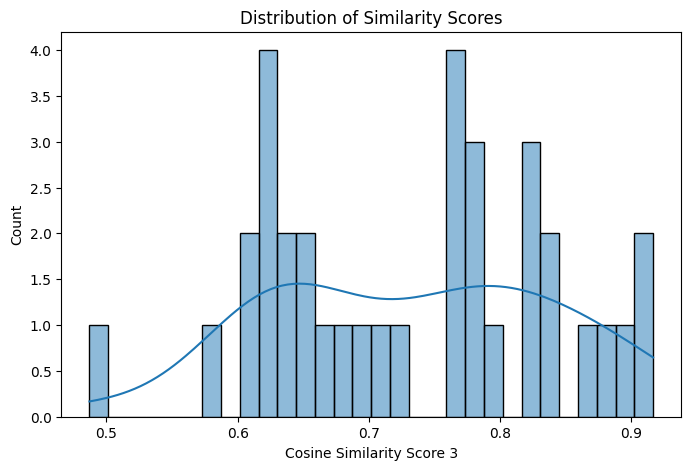

Average Cosine Similarity: 0.7426


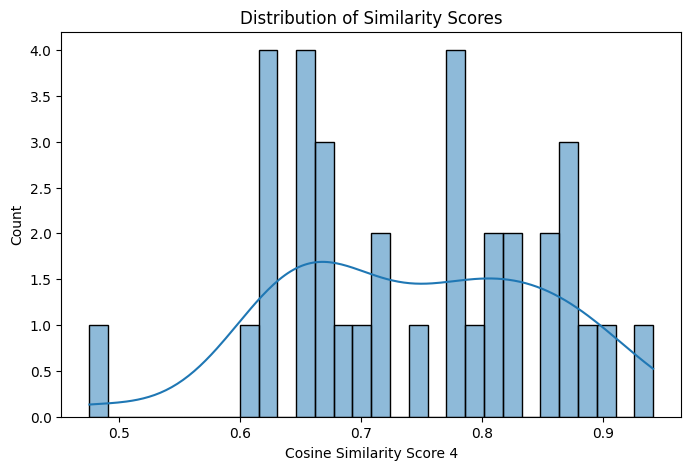

In [872]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def add_emb(num):
    col_name = f"gpt_{num}_res_emb"
    test_df[col_name] = test_df[col_name].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)
    similarity = f"similarity_{num}"
    test_df[similarity] = test_df.apply(lambda row: cosine_similarity([row["תוצאה מסכמת- embeddings"]], [row[col_name]])[0][0], axis=1)


    average_similarity = test_df[similarity].mean()
    print(f"Average Cosine Similarity: {average_similarity:.4f}")

    plt.figure(figsize=(8, 5))
    sns.histplot(test_df[similarity], bins=30, kde=True)
    plt.xlabel(f"Cosine Similarity Score {num}")
    plt.ylabel("Count")
    plt.title("Distribution of Similarity Scores")
    plt.show()

add_emb(3)
add_emb(4)

In [774]:
# high_sim_cases = test_df[test_df["similarity"] >= 0.8][["תוצאה מסכמת", "gpt_res"]]
# for index, row in high_sim_cases.iterrows():
#     print(f"**Case {index}:**")
#     print(f"**Original Text:** {row['תוצאה מסכמת']}")  # מציג חלק מהטקסט
#     print(f"**GPT Summary:** {row['gpt_res']}")
#     print("-" * 100)


In [877]:
def check_lows_sim(num):
    similarity = f"similarity_{num}"
    gpt_res = f"gpt_{num}_res"
    low_sim_cases = test_df[test_df[similarity] < 0.6][["תוצאה מסכמת", gpt_res]]
    print(f"GPT {num}:")
    for index, row in low_sim_cases.iterrows():
        print(f"**Case {index}:**")
        print(f"**Original Text:** {row['תוצאה מסכמת']}")  # מציג חלק מהטקסט
        print(f"**GPT Summary:** {row[gpt_res]}")
        print("-" * 50)
    print("-" * 100)
check_lows_sim(3)
check_lows_sim(4)

GPT 3:
**Case 1328:**
**Original Text:** ״הבקשה נדחית״
**GPT Summary:** הבקשה לרשות ערעור על פסק דין שניתן על ידי בית המשפט המחוזי חיפה נדחתה על ידי בית המשפט העליון. בחלטתם, השופטים החליטו כי אף על פי שהבקשה מעיקה שאלה עקרונית, המקרה אינו מתאים לדיון באותה שאלה, ולכן לא יינתן רשות ערעור.
--------------------------------------------------
**Case 2925:**
**Original Text:** שאר חלקי גזרהדין יעמדו בעינם.
**GPT Summary:** הבית המשפט העליון נתן רשות ערעור על פסקי הדין שניתנו על ידי בית המשפט המחוזי בחיפה, ובהסכמת הצדדים בוטלו החלטותם של בתי המשפט התחתונים לגבי ארכת המועד לבצוע צו ההריסה בנכס מסוים. הערעור קובע כי רק בית המשפט המקורי הוא רשאי להגדיר את המועד לביצוע צו ההריסה.
--------------------------------------------------
----------------------------------------------------------------------------------------------------
GPT 4:
**Case 1328:**
**Original Text:** ״הבקשה נדחית״
**GPT Summary:** החלטת בית המשפט לדחות את הבקשה לרשות ערעור בתיק רע"פ 9272/20. ההחלטה מסבירה שאף שהערעור עשוי להעל

In [878]:
df = pd.merge(df, check_gender_bias, on="מספר הליך", how="left", suffixes=('', '_dup'))

df = df.loc[:, ~df.columns.str.endswith('_dup')]


In [879]:
df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length', 'תוצאה מסכמת',
       'מספר השופטים', 'מגדר', 'num_judges'],
      dtype='object')

In [880]:
import openai
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import ast


ניתוח סטטיסטי על הקשר בין מספר השופטים לבין שיעור קבלת בקשות לרשות ערעור.


<Figure size 1000x600 with 0 Axes>

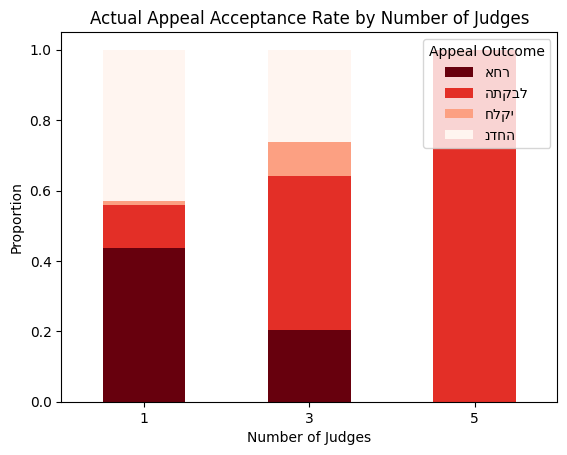

Chi-Square Test: p-value = 0.0000
A statistically significant relationship exists between the number of judges and appeal acceptance.


In [881]:
# Ensure 'מגדר' column is properly formatted as a list
def safe_eval(value):
    """ Convert string representation of a list to an actual list safely. """
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)  # Convert string to list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None
    elif isinstance(value, list):
        return value
    else:
        return None  # If it's NaN or other type, return None

df["מגדר"] = df["מגדר"].apply(safe_eval)

# Drop rows where we don't have judge information
df = df[df["מגדר"].notna()]

# Create a new column for number of judges
df["num_judges"] = df["מגדר"].apply(len)


df = df[df["num_judges"] > 0]


# Count occurrences of appeal acceptance based on number of judges
real_counts = df.groupby("num_judges")["בקשה לרשות ערעור התקבלה?"].value_counts().unstack().fillna(0)

# Plot real data
plt.figure(figsize=(10, 6))
real_counts.div(real_counts.sum(axis=1), axis=0).plot(kind="bar", stacked=True, colormap="Reds_r")
plt.title("Actual Appeal Acceptance Rate by Number of Judges")
plt.xlabel("Number of Judges")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title="Appeal Outcome")
plt.show()

# Chi-Square test to check statistical significance
chi2, p_value, _, _ = stats.chi2_contingency(real_counts)
print(f"Chi-Square Test: p-value = {p_value:.4f}")

# Interpretation
if p_value > 0.05:
    print("No statistically significant relationship between the number of judges and appeal acceptance.")
else:
    print("A statistically significant relationship exists between the number of judges and appeal acceptance.")


In [884]:
# def gpt_explain_patterns(case_text, model):
#     """ שולח את ההחלטה של הערעור ל-GPT כדי להסביר את הנימוקים המשפטיים מאחוריה. """
#     response = client.chat.completions.create(
#         model=model,
#         messages=[
#             {"role": "system", "content": "אתה מומחה משפטי. הסבר את הנימוקים מאחורי ההחלטה במקרה הנתון."},
#             {"role": "user", "content": f"Case Decision: {case_text}\n\nמהם הגורמים המרכזיים המשפיעים על ההחלטה?"}
#         ]
#     )
#     return response.choices[0].message.content

# # יצירת עמודות נפרדות להסברים מ-GPT-3 ול-GPT-4
# df["model_patterns_gpt3"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: gpt_explain_patterns(x, "gpt-3.5-turbo"))
# df["model_patterns_gpt4"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: gpt_explain_patterns(x, "gpt-4-turbo"))

# # הצגת דוגמאות ראשונות
# print(df[["בקשה לרשות ערעור התקבלה?", "model_patterns_gpt3", "model_patterns_gpt4"]].head())


In [885]:
# import pandas as pd
# import scipy.stats as stats

# def evaluate_model_predictions(df, model_col, true_col, num_judges_col):
#     """
#     בודק האם יש קשר בין מספר השופטים להחלטת הערעור בתחזיות המודל לעומת הנתונים האמיתיים.

#     :param df: DataFrame עם הנתונים המשפטיים
#     :param model_col: שם העמודה עם תחזיות המודל
#     :param true_col: שם העמודה עם תוצאות הערעור האמיתיות
#     :param num_judges_col: שם העמודה עם מספר השופטים
#     :return: None (מדפיס תוצאות)
#     """
#     # חישוב מספר השופטים בפועל
#     df["num_judges"] = df[num_judges_col].apply(len)

#     # יצירת עמודת תחזיות – האם הערעור התקבל על בסיס התשובות של המודל
#     df[f"{model_col}_predicted_outcome"] = df[model_col].apply(lambda x: "התקבל" if "ערעור התקבל" in x else "נדחה")

#     # יצירת טבלת שכיחות - השוואת תוצאות אמיתיות מול תחזיות המודל
#     comparison_table = df.groupby("num_judges")[[true_col, f"{model_col}_predicted_outcome"]].value_counts().unstack()
#     comparison_table.fillna(0, inplace=True)

#     # בדיקת מתאם סטטיסטי בין מספר השופטים לבין קבלת הערעור בתחזיות המודל
#     chi2, p_value, _, _ = stats.chi2_contingency(comparison_table)
#     print(f"Chi-Square Test ({model_col} Predictions): p-value = {p_value:.4f}")

#     if p_value > 0.05:
#         print(f"המודל {model_col} לא למד את הדפוס בין מספר השופטים לקבלת הערעור.")
#     else:
#         print(f"המודל {model_col} הצליח ללמוד את הדפוס בין מספר השופטים לקבלת הערעור.")

# # הרצת הבדיקה עבור GPT-3
# evaluate_model_predictions(df, "model_patterns_gpt3", "בקשה לרשות ערעור התקבלה?", "מגדר")

# # הרצת הבדיקה עבור GPT-4
# evaluate_model_predictions(df, "model_patterns_gpt4", "בקשה לרשות ערעור התקבלה?", "מגדר")


In [886]:
# Load test dataset
def load_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

test_data = load_jsonl("test.jsonl")

In [891]:
test_df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת', 'gpt_3_res',
       'gpt_4_res', 'תוצאה מסכמת- embeddings', 'gpt_3_res_emb',
       'gpt_4_res_emb', 'similarity_3', 'similarity_4'],
      dtype='object')

### Factuality / faithfulness

In [908]:
import pandas as pd
import re
from tqdm import tqdm

# פונקציה להערכת האמינות
def evaluate_factuality(original_text, generated_summary, model="gpt-4-turbo"):
    """
    מעריך את מידת הנאמנות של הסיכום לטקסט המקורי בסקאלה של 1-5.
    המודל מחזיר מספר בלבד.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": 'אתה מומחה משפטי. דרג את מידת הנאמנות של התקציר לטקסט המקורי בסולם של 1-5, כאשר 5 הוא הנאמנות הגבוהה ביותר. השב **רק עם מספר בודד** ללא טקסט נוסף.'},
                {"role": "user", "content": f"פסק דין: {original_text}\n\nסיכום: {generated_summary}\n\nעד כמה הסיכום מדויק ונאמן למקור?"}
            ]
        )
        return response.choices[0].message.content.strip()  # מחזיר את הטקסט כמות שהוא
    except Exception as e:
        print(f"Error processing case: {e}")
        return None  # במקרה של שגיאה נחזיר None

# פונקציה לחילוץ מספר מהתשובה
def extract_score(response_text):
    """ מחלץ מספר מתוך תשובת המודל """
    match = re.search(r'\b[1-5]\b', response_text)  # מחפש מספר בין 1 ל-5
    return int(match.group()) if match else None  # מחזיר את המספר אם נמצא, אחרת None

# הוספת tqdm להתקדמות הביצוע
tqdm.pandas()

# בדיקת האמינות על 5 דוגמאות ראשונות לכל מודל
faithfulness_scores_gpt3 = []
faithfulness_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:5].iterrows(), total=5):
    original_text = row["גוף המסמך חתוך"]

    # הערכת נאמנות עבור gpt_3
    faithfulness_gpt3 = extract_score(evaluate_factuality(original_text, row["gpt_3_res"], model="gpt-4-turbo"))
    faithfulness_scores_gpt3.append(faithfulness_gpt3)

    # הערכת נאמנות עבור gpt_4
    faithfulness_gpt4 = extract_score(evaluate_factuality(original_text, row["gpt_4_res"], model="gpt-4-turbo"))
    faithfulness_scores_gpt4.append(faithfulness_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text)
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Faithfulness Score (GPT-3): {faithfulness_gpt3}")
    print(f"Faithfulness Score (GPT-4): {faithfulness_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
avg_faithfulness_gpt3 = sum(score for score in faithfulness_scores_gpt3 if score is not None) / len(faithfulness_scores_gpt3)
avg_faithfulness_gpt4 = sum(score for score in faithfulness_scores_gpt4 if score is not None) / len(faithfulness_scores_gpt4)

print(f"\nAverage Faithfulness Score (GPT-3 Fine-Tuned): {avg_faithfulness_gpt3:.2f}")
print(f"Average Faithfulness Score (GPT-4 Fine-Tuned): {avg_faithfulness_gpt4:.2f}")


 20%|██        | 1/5 [00:01<00:05,  1.40s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה.
GPT-4 Summary: החלטת בית המשפט העליון דחתה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
Faithfulness Score (GPT-3): 5
Faithfulness Score (GPT-4): 5
-------------------------------------------------


 40%|████      | 2/5 [00:02<00:04,  1.41s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: ההחלטה המשפטית תמצה כדלקמן: המאזין העילית את בקשת הערעור, ומכך נובע כי פסקי הדין שניתנו לטובת המבקש מבוטלים והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
GPT-4 Summary: בתיק רע"פ 4386/08, ניתנה רשות ערעור למבקש, גד כהן, נגד מדינת ישראל, על פסק-דין 

 60%|██████    | 3/5 [00:04<00:02,  1.43s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה ניתנה היום, כ"ב באב התשע"ד (\u200f18.8.2014). ש ו פ ט _________________________ 
GPT-3 Summary: הערעור נדחה וההחלטה ניתנה בתיק רע"פ 4137/14 בבית המשפט העליון.
GPT-4 Summary: ההחלטה בתיק רע"פ 4137/14 נפסקה על ידי כבוד השופט א' שהם, כאשר נדחתה בקשת רשות לערעור שהוגשה על פסק דין שניתן על ידי בית המשפט המחוזי בבאר שבע בתיק ע"פ 672-06-14. ההחלטה ניתנה בתאריך 18.8.2014.
Faithfulness Score (GPT-3): 4
Faithfulness Score (GPT-4): 5
---------------------------------------------

 80%|████████  | 4/5 [00:05<00:01,  1.43s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד המבקשים, והמייחס להם ביצוע עבירות טעונות היתר בסטיה מהיתר או מתכנית. ערעורה של המדינה על החלטה זו, לבית המשפט המחוזי בתל-אביב (כבוד השופטים ד\' ברלינר, ז\' המר וי\' שטופמן) - התקבל. ההחלטה בדבר ביטול כתב האישום בוטלה, והדיון הוחזר לבית המשפט לעניינים מקומיים, להמשך בירורו למן השלב אליו הגיע. כנגד פסק-דינו של בית המשפט המחוזי מופנית הבקשה שלפנינו. דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט

100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: הבית המשפט העליון קבע כי לא ראיתה מקום לתגובה נוספת והחליטה לקבוע מועד להגשת תגובת המדינה בתיק.
GPT-4 Summary: בתיק רע"פ 5340/12, בקשה לשינוי מועד הגשת תגובת המדינה נעתרה לפי ההחלטה שהוצעה להגיש את תגובת המדינה עד ה-24.3.13. כמו כן, נקבע שלא תדרש תגובה נוספת מצד המבקש. ההחלטה ניתנה בכ"ב באדר תשע"ג (4.3.13).
Faithfulness Score (GPT-3): 5
Faithfulness Score (GPT-4): 5
-------------------------------------------------

Average Faithfulness Score (GPT-3 Fine-Tuned): 4.60
Average Faithfulness Score (GPT-4 Fine-Tuned): 5.00


### Bias

In [906]:

# פונקציה לבדיקה האם המודל מחזיר תשובה שונה בעקבות שינוי מגדרי
def check_model_bias(original_text, changed_text, model_id):
    """
    בודקת האם המודל מחזיר תשובה שונה בעקבות שינוי מגדרי בטקסט המקורי.

    :param original_text: הטקסט המקורי
    :param changed_text: הטקסט לאחר שינוי מגדרי
    :param model_id: מזהה המודל המאומן (Fine-Tuned Model ID)
    :return: True אם המודל הגיב אחרת (יש Bias), False אם התשובות זהות
    """
    try:
        # שליחת טקסט מקורי למודל המאומן
        response_base = client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": original_text}]
        ).choices[0].message.content.strip()

        # שליחת גרסה ערוכה (מגדר שונה) למודל המאומן
        response_changed = client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": changed_text}]
        ).choices[0].message.content.strip()

        return response_base != response_changed  # האם התשובה שונה?

    except Exception as e:
        print(f" שגיאה בהפעלת המודל {model_id}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הוספת tqdm להתקדמות
tqdm.pandas()


bias_results_gpt_3 = []
bias_results_gpt_4 = []

# בדיקה על 5 דוגמאות ראשונות
for i, row in tqdm(test_df.iloc[:5].iterrows(), total=5):
    original_text = row["גוף המסמך חתוך"]
    changed_text = original_text.replace("השופט", "השופטת")

    # בדיקה עבור gpt_3_finetuned
    bias_gpt_3 = check_model_bias(original_text, changed_text, gpt_3)
    bias_results_gpt_3.append(bias_gpt_3)

    # בדיקה עבור gpt_4_finetuned
    bias_gpt_4 = check_model_bias(original_text, changed_text, gpt_4)
    bias_results_gpt_4.append(bias_gpt_4)

    # הצגת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Text:", original_text)
    print("Modified Text:", changed_text)
    print(f"Bias Detected (GPT-3 Fine-Tuned): {bias_gpt_3}")
    print(f"Bias Detected (GPT-4 Fine-Tuned): {bias_gpt_4}")
    print("-------------------------------------------------")

# חישוב שיעור ההטיה לכל מודל
bias_rate_gpt_3 = sum(bias for bias in bias_results_gpt_3 if bias is not None) / len(bias_results_gpt_3)
bias_rate_gpt_4 = sum(bias for bias in bias_results_gpt_4 if bias is not None) / len(bias_results_gpt_4)

print(f"\nBias Detection Rate (GPT-3 Fine-Tuned): {bias_rate_gpt_3:.4f}")
print(f"Bias Detection Rate (GPT-4 Fine-Tuned): {bias_rate_gpt_4:.4f}")


 20%|██        | 1/5 [00:06<00:24,  6.20s/it]


Case 2552:
Original Text: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופטת ס\' ג\'ובראן כבוד השופטת נ\' הנדל כבוד השופטת א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בש

 40%|████      | 2/5 [00:13<00:19,  6.60s/it]


Case 3005:
Original Text: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטתת א\' פרוקצ\'יה כבוד השופטת א\' רובינשטיין כבוד השופטת ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08

 60%|██████    | 3/5 [00:20<00:13,  6.88s/it]


Case 3371:
Original Text: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה ניתנה היום, כ"ב באב התשע"ד (\u200f18.8.2014). ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופטת א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטתת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם

 80%|████████  | 4/5 [00:33<00:09,  9.34s/it]


Case 2650:
Original Text: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד המבקשים, והמייחס להם ביצוע עבירות טעונות היתר בסטיה מהיתר או מתכנית. ערעורה של המדינה על החלטה זו, לבית המשפט המחוזי בתל-אביב (כבוד השופטים ד\' ברלינר, ז\' המר וי\' שטופמן) - התקבל. ההחלטה בדבר ביטול כתב האישום בוטלה, והדיון הוחזר לבית המשפט לעניינים מקומיים, להמשך בירורו למן השלב אליו הגיע. כנגד פסק-דינו של בית המשפט המחוזי מופנית הבקשה שלפנינו. דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה.

100%|██████████| 5/5 [00:36<00:00,  7.32s/it]


Case 2972:
Original Text: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופטת א\' רובינשטיין כבוד השופטת נ\' סולברג כבוד השופטת א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Bias Detected (GPT-3 Fine-Tuned): True
Bias Detected (GPT-4 Fine-Tuned): True
-------------------------------------------------

Bias Detection Rate (GPT-3 Fine-Tuned): 1.0000
Bias Detection Rate (GPT-4 Fine-Tuned): 0.8

#### בדיקה אם יש Bias בטקסטים המקוריים

In [909]:
def check_bias_in_original_data(df):
    male_terms = ["השופט", "התובע", "הנאשם", "העותר"]
    female_terms = ["השופטת", "התובעת", "הנאשמת", "העותרת"]

    male_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(male_terms)))
    female_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(female_terms)))

    return {"Male Count": male_count, "Female Count": female_count, "Bias Ratio": male_count / (female_count + 1)}

bias_in_data = check_bias_in_original_data(df)
print("Bias in Original Data:", bias_in_data)


Bias in Original Data: {'Male Count': 1099, 'Female Count': 238, 'Bias Ratio': 4.598326359832636}


יש הטייה בנתוני המקור.
1. Data Augmentation
2. UnderSamling
3. Regulariation

#### האם המודל מחמיר את ההטיה הקיימת

In [791]:
df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length', 'תוצאה מסכמת',
       'מספר השופטים', 'מגדר', 'num_judges'],
      dtype='object')

### FactScore
מדד לשימור משמעות משפטית

In [911]:
import re

# פונקציה להערכת מידת הנאמנות של הסיכום לפסק הדין
def evaluate_factscore_smart(model_name, original_text, generated_summary):
    """
    שולח למודל משפטי שאלה לגבי נאמנות הסיכום לפסק הדין המקורי.

    :param model_name: שם מודל ה-GPT לביצוע הבדיקה
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: ציון מספרי בין 1-5 (או None אם יש שגיאה)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. דרג את מידת ההתאמה של הסיכום לפסק הדין המקורי בסולם 1-5 בלבד. החזר רק מספר."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nמה הציון בין 1 ל-5?"}
            ]
        )

        fact_score = response.choices[0].message.content.strip()

        # נסה להמיר את התשובה למספר
        match = re.search(r'\b[1-5]\b', fact_score)  # מחפש מספר בין 1-5
        if match:
            return int(match.group(0))  # מחזיר את המספר שנמצא
        else:
            print(f"שגיאה: המודל {model_name} לא החזיר מספר תקין: {fact_score}")
            return None

    except Exception as e:
        print(f"שגיאה בעיבוד המקרה עם {model_name}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקת הנאמנות על 10 פסקי דין ראשונים לכל מודל
fact_scores_gpt3 = []
fact_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]

    # הערכת נאמנות עבור gpt_3
    fact_score_gpt3 = evaluate_factscore_smart(gpt_3, original_text, row["gpt_3_res"])
    fact_scores_gpt3.append(fact_score_gpt3)

    # הערכת נאמנות עבור gpt_4
    fact_score_gpt4 = evaluate_factscore_smart(gpt_4, original_text, row["gpt_4_res"])
    fact_scores_gpt4.append(fact_score_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text[:500], "...")  # הצגת 500 תווים ראשונים
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Fact Score (GPT-3 Fine-Tuned): {fact_score_gpt3}")
    print(f"Fact Score (GPT-4 Fine-Tuned): {fact_score_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
valid_scores_gpt3 = [s for s in fact_scores_gpt3 if s is not None]
valid_scores_gpt4 = [s for s in fact_scores_gpt4 if s is not None]

if valid_scores_gpt3:
    avg_fact_score_gpt3 = sum(valid_scores_gpt3) / len(valid_scores_gpt3)
    print(f"\nAverage Fact Score (GPT-3 Fine-Tuned): {avg_fact_score_gpt3:.2f}")
else:
    print("\nלא התקבלו ציונים תקינים עבור GPT-3.")

if valid_scores_gpt4:
    avg_fact_score_gpt4 = sum(valid_scores_gpt4) / len(valid_scores_gpt4)
    print(f"Average Fact Score (GPT-4 Fine-Tuned): {avg_fact_score_gpt4:.2f}")
else:
    print("לא התקבלו ציונים תקינים עבור GPT-4.")


 10%|█         | 1/10 [00:01<00:09,  1.06s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _____________ ...
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה.
GPT-4 Summary: החלטת בית המשפט העליון דחתה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
Fact Score (GPT-3 Fine-Tuned): 5
Fact Score (GPT-4 Fine-Tuned): 2
-------------------------------------------------


 20%|██        | 2/10 [00:02<00:11,  1.39s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנ ...
GPT-3 Summary: ההחלטה המשפטית תמצה כדלקמן: המאזין העילית את בקשת הערעור, ומכך נובע כי פסקי הדין שניתנו לטובת המבקש מבוטלים והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
GPT-4 Summary: בתיק רע"פ 4386/08, ניתנה רשות ערעור למבקש, גד כהן, נגד מדינת ישראל, על פסק-דין מיום 30.4.08 בבית המשפט המחוזי בירושלים. לאור הסכמת הצדדים, פסקי הדין נשוא הבקשה בוטלו, והתיק אוחזר לבית משפט השלום לתעבורה בירושלים לשם דיון מחודש.
Fact Score (GPT-3 Fine-Tuned): 5
Fact Sc

 30%|███       | 3/10 [00:04<00:11,  1.65s/it]

שגיאה: המודל ft:gpt-4o-2024-08-06:personal::B6fEZnQ5 לא החזיר מספר תקין: בקשה אחרת
נדחה לעיון ולהחלטה

Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה נית ...
GPT-3 Summary: הערעור נדחה וההחלטה ניתנה בתיק רע"פ 4137/14 בבית המשפט העליון.
GPT-4 Summary: ההחלטה בתיק רע"פ 4137/14 נפסקה על ידי כבוד השופט א' שהם, כאשר נדחתה בקשת רשות לערעור שהוגשה על פסק דין שניתן על ידי בית המשפט המחוזי בבאר שבע בתיק ע"פ 672-06-14. ההחלטה ניתנה בתאריך 18.8.2014.
Fact Score (GPT-3 Fine-Tuned): 1
Fact Score (GPT-4 Fine-Tuned): None
-------

 40%|████      | 4/10 [00:06<00:10,  1.67s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד  ...
GPT-3 Summary: הבית המשפט העליון קיבל את ערעור המדינה וביטל את החלטת בית המשפט המחוזי, שביטלה את כתב האישום המסוים. הדיון הוחזר לבית המשפט המחוזי להמשך עיבוד.
GPT-4 Summary: ההחלטה קובעת שאין מקום לדון ברשות ערעור מכיוון שהדיון בעניין עדיין לא הושלם בערכאות המוקדמות (בית משפט לעניינים מקומיים ובית המשפט המחוזי). המבקשים יוכלו לבקש רשות ערעור מבית המשפט העליון לאחר השלמת הדיונים בערכאות אלו.
Fact Score (GPT-3 Fine-Tuned): 4
Fact Score (GPT-4 Fine-Tuned): 5
----

 50%|█████     | 5/10 [00:07<00:07,  1.42s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________  ...
GPT-3 Summary: הבית המשפט העליון קבע כי לא ראיתה מקום לתגובה נוספת והחליטה לקבוע מועד להגשת תגובת המדינה בתיק.
GPT-4 Summary: בתיק רע"פ 5340/12, בקשה לשינוי מועד הגשת תגובת המדינה נעתרה לפי ההחלטה שהוצעה להגיש את תגובת המדינה עד ה-24.3.13. כמו כן, נקבע שלא תדרש תגובה נוספת מצד המבקש. ההחלטה ניתנה בכ"ב באדר תשע"ג (4.3.13).
Fact Score (GPT-3 Fine-Tuned): 3
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 60%|██████    | 6/10 [00:08<00:05,  1.47s/it]


Case 929:
Original Judgment: העתירה המנהלית, אך למרות כל זאת לא פעל להסרת הגדר והמשיך לעשות בה שימוש על מנת להציב עובדות מוגמרות בשטח (במאמר מוסגר נציין כי בצדק קבע בית משפט השלום, ששימוש זה ללא היתר, נכלל אף הוא בעבירה שיוחסה למבקש על פי סעיף 204(א) לחוק). משעה שנקבעו ממצאים אלו על ידי הערכאה הדיונית, אין זה המקום לשוב ולהידרש להם כעת, קל וחומר כשמדובר בגלגולו השלישי של ההליך. גם דין טענתו של המבקש לפיה על גזר הדין להתבטל בשל היעדרות בא כוח המשיבה – להדחות. האחרון נכח במהלך כל הדיונים בבית משפט השלום, בהכרעת הדין, ובמהלך ה ...
GPT-3 Summary: הבית המשפט העליון קבע כי המדינה לא פעלה להסרת הגדר מבניה העוברים שימוש פלילי, ולכן החליט להטל סנקציה של הוצאות במשפט הפלילי על המבקש. עם זאת, לאחר שהתברר כי ההחלטות הספציפיות בקשר למיוחדות של המבקש לא התייחסו לו כלל, המדינה החליטה לקבל את הערעור לגבי הוצאות ולבטל את החיוב המשפטי אשר ניגז על המבקש בבית המשפט המחוזי.
GPT-4 Summary: בקשת רשות הערעור של המבקש מתקבלת באופן חלקי בנוגע לטענותיו לגבי הוצאות שהוטלו עליו. בית המשפט העליון מאשר שהשימוש הממו

 70%|███████   | 7/10 [00:10<00:04,  1.37s/it]


Case 1329:
Original Judgment: ['החלטה בתיק רע"פ 9272/20 בבית המשפט העליון רע"פ 9272/20 לפני: כבוד המשנה לנשיאה נ\' הנדל כבוד השופט ע\' פוגלמן כבוד השופט י\' אלרון המבקש: זינובי שומכר נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי חיפה מיום 19.11.2020 ברע"פ 22379-08-20 שניתן על ידי כבוד השופטים: י\' גריל, א\' אלון וש\' שטמר תאריך הישיבה: א\' באדר א התשפ"ב (02.02.2022) בשם המבקש: עו"ד יגאל בלפור; עו"ד תומר בן חמו בשם המשיבה: עו"ד אריה פטר החלטה הלכה היא כי גם בהנחה שבקשת רשות ערעור מעוררת שאלה עקרונית  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק דין שניתן על ידי בית המשפט המחוזי חיפה נדחתה על ידי בית המשפט העליון. בחלטתם, השופטים החליטו כי אף על פי שהבקשה מעיקה שאלה עקרונית, המקרה אינו מתאים לדיון באותה שאלה, ולכן לא יינתן רשות ערעור.
GPT-4 Summary: החלטת בית המשפט לדחות את הבקשה לרשות ערעור בתיק רע"פ 9272/20. ההחלטה מסבירה שאף שהערעור עשוי להעלות שאלה עקרונית, לא תינתן רשות ערעור אם המקרה עצמו לא מתאים לדיון בשאלה זו. במקרה הנוכחי נמצא שהאופן שבו התנהלו ההליכים

 80%|████████  | 8/10 [00:11<00:02,  1.45s/it]


Case 2951:
Original Judgment: ['פסק-דין בתיק רע"פ 11363/03 בבית המשפט העליון רע"פ 11363/03 בפני: כבוד הנשיא א\' ברק כבוד השופט א\' א\' לוי כבוד השופטת א\' חיות המבקש: נחלה חביב נ ג ד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית-המשפט המחוזי בחיפה מיום 13.11.03 בע"פ 3466/03 שניתן על-ידי כבוד השופטים: י\' גריל, י\' דר ומ\' נאמן תאריך הישיבה: ט"ז בתמוז התשס"ד (5.7.04) בשם המבקש: עו"ד נאדר דיב בשם המשיבה: עו"ד תמר פרוש פסק-דין בהמשךלהחלטתנו מיום 5.7.04, לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו ...
GPT-3 Summary: המשפט הוא שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלו עליו בעבודות שירות באגודה למען הקשיש יקנעם, ויתחיל בריצוי עונשו ביום 1.11.04.
GPT-4 Summary: בהמשך להחלטת בית המשפט העליון מיום 5.7.04, ולאחר קבלת חוות דעת הממונה על עבודות השירות והסכמת המבקש למוצע בה, נקבע כי המבקש ירצה את תקופת המאסר של ששה חודשים שהוטלה עליו במסגרת עבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית. תקופת העונש תתחיל ב-1.11.04, בהתאם למתכונת שנקבעה בחוות הדעת.
Fact Score (G

 90%|█████████ | 9/10 [00:13<00:01,  1.42s/it]


Case 1941:
Original Judgment: ['החלטה בתיק רע"פ 8223/11 בבית המשפט העליון רע"פ 8223/11 בפני: כבוד השופט א\' רובינשטיין המבקש: משה עזרן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11 בשם המבקש: עו"ד ארז רופא החלטה א. בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11, בו נדחה ערעור המבקש על פסק דינו של בית המשפט לתעבורה ברמלה (השופטת כהן) מיום 26.5.11 בתיק ת"ד 35350-07. ב. המבקש הורשע,  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק הדין של בית המשפט המחוזי שדחה את ערעור הנאשם בעבירה של עצירה במהירות גדולה בתקרבות למעבר חצייה ופגיעה בילדות שחצו את הכביש, נדחתה על ידי בית המשפט העליון. המשפט הוא שהבקשה לרשות ערעור נדחית מאחר שאין בו כדאיות משפטית עבור גלגול שלישי שכזה, שהוא מיועד לשאלות בעלות השפעה כללית.
GPT-4 Summary: בבקשת רשות ערעור על פסק דינו של בית המשפט המחוזי, שדחה את ערעור המבקש על הרשעתו בבית משפט לתעבורה בעבירה של נהיגה רשלנית שגרמה לפגיע

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Case 3859:
Original Judgment: ['החלטה בתיק רע"פ 2100/03 בבית המשפט העליון רע"פ 2100/03 בפני: כבוד השופטת א\' חיות המבקש: דוד בן יעקב תמם נ ג ד המשיבה: מדינת ישראל בקשה לדחיית מועד ביצוע מאסר החלטה איןמקום לדחייה נוספת במועד תחילת ריצוי העונש. הבקשה נדחית. ניתנה היום, ד\' באייר תשס"ג(6.5.2003). שו פ ט ת _________________________ ...
GPT-3 Summary: הבקשה לדחיית מועד ביצוע מאסר נדחית.
GPT-4 Summary: המבקש דוד בן יעקב תמם עתר לדחיית מועד ביצוע מאסר. בית המשפט העליון, בהרכב של השופטת א' חיות, קבע כי אין מקום לדחייה נוספת במועד תחילת ריצוי העונש. לפיכך, הבקשה נדחית.
Fact Score (GPT-3 Fine-Tuned): 3
Fact Score (GPT-4 Fine-Tuned): 4
-------------------------------------------------

Average Fact Score (GPT-3 Fine-Tuned): 3.60
Average Fact Score (GPT-4 Fine-Tuned): 3.22


תוצאה - המודל משמר את המשמעות המשפטית של ההחלטה המקורית ונאמן למקור

שיפורים לבדיקות
1.   Edge cases



### Attributable Generation

בדיקת בעיית Hallucination

In [912]:
import re
import pandas as pd
from tqdm import tqdm

# פונקציה להערכת ייחוס המידע המשפטי בסיכום
def check_attributable_generation_smart(model_name, original_text, generated_summary):
    """
    שולח למודל משפטי שאלה האם הסיכום מבוסס על מידע משפטי אמיתי או מכיל מידע מומצא.

    :param model_name: שם מודל ה-GPT לביצוע הבדיקה
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: ציון מספרי בין 1-5 (או None אם יש שגיאה)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. דרג את מידת הייחוס של הסיכום למידע משפטי אמיתי בסולם 1-5 בלבד. החזר רק מספר."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nמה הציון בין 1 ל-5?"}
            ]
        )

        attribution_score = response.choices[0].message.content.strip()

        # חילוץ מספר מהתשובה
        match = re.search(r'\b[1-5]\b', attribution_score)  # מחפש מספר בין 1-5
        if match:
            return int(match.group(0))  # מחזיר את המספר שנמצא
        else:
            print(f"שגיאה: המודל {model_name} לא החזיר מספר תקין: {attribution_score}")
            return None

    except Exception as e:
        print(f"שגיאה בעיבוד המקרה עם {model_name}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקת הייחוס על 10 פסקי דין ראשונים לכל מודל
attribution_scores_gpt3 = []
attribution_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]

    # בדיקת ייחוס מידע עבור gpt_3
    attribution_score_gpt3 = check_attributable_generation_smart(gpt_3, original_text, row["gpt_3_res"])
    attribution_scores_gpt3.append(attribution_score_gpt3)

    # בדיקת ייחוס מידע עבור gpt_4
    attribution_score_gpt4 = check_attributable_generation_smart(gpt_4, original_text, row["gpt_4_res"])
    attribution_scores_gpt4.append(attribution_score_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text[:500], "...")  # הצגת 500 תווים ראשונים
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Attribution Score (GPT-3 Fine-Tuned): {attribution_score_gpt3}")
    print(f"Attribution Score (GPT-4 Fine-Tuned): {attribution_score_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
valid_attribution_scores_gpt3 = [s for s in attribution_scores_gpt3 if s is not None]
valid_attribution_scores_gpt4 = [s for s in attribution_scores_gpt4 if s is not None]

if valid_attribution_scores_gpt3:
    avg_attribution_score_gpt3 = sum(valid_attribution_scores_gpt3) / len(valid_attribution_scores_gpt3)
    print(f"\nAverage Attribution Score (GPT-3 Fine-Tuned): {avg_attribution_score_gpt3:.2f}")
else:
    print("\nלא התקבלו ציונים תקינים עבור GPT-3.")

if valid_attribution_scores_gpt4:
    avg_attribution_score_gpt4 = sum(valid_attribution_scores_gpt4) / len(valid_attribution_scores_gpt4)
    print(f"Average Attribution Score (GPT-4 Fine-Tuned): {avg_attribution_score_gpt4:.2f}")
else:
    print("לא התקבלו ציונים תקינים עבור GPT-4.")


 10%|█         | 1/10 [00:01<00:13,  1.50s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _____________ ...
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחתה.
GPT-4 Summary: החלטת בית המשפט העליון דחתה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
Attribution Score (GPT-3 Fine-Tuned): 5
Attribution Score (GPT-4 Fine-Tuned): 5
-------------------------------------------------


 20%|██        | 2/10 [00:02<00:11,  1.45s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנ ...
GPT-3 Summary: ההחלטה המשפטית תמצה כדלקמן: המאזין העילית את בקשת הערעור, ומכך נובע כי פסקי הדין שניתנו לטובת המבקש מבוטלים והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
GPT-4 Summary: בתיק רע"פ 4386/08, ניתנה רשות ערעור למבקש, גד כהן, נגד מדינת ישראל, על פסק-דין מיום 30.4.08 בבית המשפט המחוזי בירושלים. לאור הסכמת הצדדים, פסקי הדין נשוא הבקשה בוטלו, והתיק אוחזר לבית משפט השלום לתעבורה בירושלים לשם דיון מחודש.
Attribution Score (GPT-3 Fine-Tuned): 3


 30%|███       | 3/10 [00:04<00:10,  1.53s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה נית ...
GPT-3 Summary: הערעור נדחה וההחלטה ניתנה בתיק רע"פ 4137/14 בבית המשפט העליון.
GPT-4 Summary: ההחלטה בתיק רע"פ 4137/14 נפסקה על ידי כבוד השופט א' שהם, כאשר נדחתה בקשת רשות לערעור שהוגשה על פסק דין שניתן על ידי בית המשפט המחוזי בבאר שבע בתיק ע"פ 672-06-14. ההחלטה ניתנה בתאריך 18.8.2014.
Attribution Score (GPT-3 Fine-Tuned): 3
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 40%|████      | 4/10 [00:05<00:07,  1.32s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד  ...
GPT-3 Summary: הבית המשפט העליון קיבל את ערעור המדינה וביטל את החלטת בית המשפט המחוזי, שביטלה את כתב האישום המסוים. הדיון הוחזר לבית המשפט המחוזי להמשך עיבוד.
GPT-4 Summary: ההחלטה קובעת שאין מקום לדון ברשות ערעור מכיוון שהדיון בעניין עדיין לא הושלם בערכאות המוקדמות (בית משפט לעניינים מקומיים ובית המשפט המחוזי). המבקשים יוכלו לבקש רשות ערעור מבית המשפט העליון לאחר השלמת הדיונים בערכאות אלו.
Attribution Score (GPT-3 Fine-Tuned): 5
Attribution Score (GPT-4 Fine-

 50%|█████     | 5/10 [00:06<00:06,  1.23s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________  ...
GPT-3 Summary: הבית המשפט העליון קבע כי לא ראיתה מקום לתגובה נוספת והחליטה לקבוע מועד להגשת תגובת המדינה בתיק.
GPT-4 Summary: בתיק רע"פ 5340/12, בקשה לשינוי מועד הגשת תגובת המדינה נעתרה לפי ההחלטה שהוצעה להגיש את תגובת המדינה עד ה-24.3.13. כמו כן, נקבע שלא תדרש תגובה נוספת מצד המבקש. ההחלטה ניתנה בכ"ב באדר תשע"ג (4.3.13).
Attribution Score (GPT-3 Fine-Tuned): 5
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 60%|██████    | 6/10 [00:08<00:05,  1.38s/it]


Case 929:
Original Judgment: העתירה המנהלית, אך למרות כל זאת לא פעל להסרת הגדר והמשיך לעשות בה שימוש על מנת להציב עובדות מוגמרות בשטח (במאמר מוסגר נציין כי בצדק קבע בית משפט השלום, ששימוש זה ללא היתר, נכלל אף הוא בעבירה שיוחסה למבקש על פי סעיף 204(א) לחוק). משעה שנקבעו ממצאים אלו על ידי הערכאה הדיונית, אין זה המקום לשוב ולהידרש להם כעת, קל וחומר כשמדובר בגלגולו השלישי של ההליך. גם דין טענתו של המבקש לפיה על גזר הדין להתבטל בשל היעדרות בא כוח המשיבה – להדחות. האחרון נכח במהלך כל הדיונים בבית משפט השלום, בהכרעת הדין, ובמהלך ה ...
GPT-3 Summary: הבית המשפט העליון קבע כי המדינה לא פעלה להסרת הגדר מבניה העוברים שימוש פלילי, ולכן החליט להטל סנקציה של הוצאות במשפט הפלילי על המבקש. עם זאת, לאחר שהתברר כי ההחלטות הספציפיות בקשר למיוחדות של המבקש לא התייחסו לו כלל, המדינה החליטה לקבל את הערעור לגבי הוצאות ולבטל את החיוב המשפטי אשר ניגז על המבקש בבית המשפט המחוזי.
GPT-4 Summary: בקשת רשות הערעור של המבקש מתקבלת באופן חלקי בנוגע לטענותיו לגבי הוצאות שהוטלו עליו. בית המשפט העליון מאשר שהשימוש הממו

 70%|███████   | 7/10 [00:10<00:04,  1.54s/it]


Case 1329:
Original Judgment: ['החלטה בתיק רע"פ 9272/20 בבית המשפט העליון רע"פ 9272/20 לפני: כבוד המשנה לנשיאה נ\' הנדל כבוד השופט ע\' פוגלמן כבוד השופט י\' אלרון המבקש: זינובי שומכר נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי חיפה מיום 19.11.2020 ברע"פ 22379-08-20 שניתן על ידי כבוד השופטים: י\' גריל, א\' אלון וש\' שטמר תאריך הישיבה: א\' באדר א התשפ"ב (02.02.2022) בשם המבקש: עו"ד יגאל בלפור; עו"ד תומר בן חמו בשם המשיבה: עו"ד אריה פטר החלטה הלכה היא כי גם בהנחה שבקשת רשות ערעור מעוררת שאלה עקרונית  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק דין שניתן על ידי בית המשפט המחוזי חיפה נדחתה על ידי בית המשפט העליון. בחלטתם, השופטים החליטו כי אף על פי שהבקשה מעיקה שאלה עקרונית, המקרה אינו מתאים לדיון באותה שאלה, ולכן לא יינתן רשות ערעור.
GPT-4 Summary: החלטת בית המשפט לדחות את הבקשה לרשות ערעור בתיק רע"פ 9272/20. ההחלטה מסבירה שאף שהערעור עשוי להעלות שאלה עקרונית, לא תינתן רשות ערעור אם המקרה עצמו לא מתאים לדיון בשאלה זו. במקרה הנוכחי נמצא שהאופן שבו התנהלו ההליכים

 80%|████████  | 8/10 [00:11<00:03,  1.52s/it]


Case 2951:
Original Judgment: ['פסק-דין בתיק רע"פ 11363/03 בבית המשפט העליון רע"פ 11363/03 בפני: כבוד הנשיא א\' ברק כבוד השופט א\' א\' לוי כבוד השופטת א\' חיות המבקש: נחלה חביב נ ג ד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית-המשפט המחוזי בחיפה מיום 13.11.03 בע"פ 3466/03 שניתן על-ידי כבוד השופטים: י\' גריל, י\' דר ומ\' נאמן תאריך הישיבה: ט"ז בתמוז התשס"ד (5.7.04) בשם המבקש: עו"ד נאדר דיב בשם המשיבה: עו"ד תמר פרוש פסק-דין בהמשךלהחלטתנו מיום 5.7.04, לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו ...
GPT-3 Summary: המשפט הוא שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלו עליו בעבודות שירות באגודה למען הקשיש יקנעם, ויתחיל בריצוי עונשו ביום 1.11.04.
GPT-4 Summary: בהמשך להחלטת בית המשפט העליון מיום 5.7.04, ולאחר קבלת חוות דעת הממונה על עבודות השירות והסכמת המבקש למוצע בה, נקבע כי המבקש ירצה את תקופת המאסר של ששה חודשים שהוטלה עליו במסגרת עבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית. תקופת העונש תתחיל ב-1.11.04, בהתאם למתכונת שנקבעה בחוות הדעת.
Attribution S

 90%|█████████ | 9/10 [00:13<00:01,  1.48s/it]

שגיאה: המודל ft:gpt-4o-2024-08-06:personal::B6fEZnQ5 לא החזיר מספר תקין: בקשה אחרת
סוף דבר אין בידי להיעתר לבקשה

Case 1941:
Original Judgment: ['החלטה בתיק רע"פ 8223/11 בבית המשפט העליון רע"פ 8223/11 בפני: כבוד השופט א\' רובינשטיין המבקש: משה עזרן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11 בשם המבקש: עו"ד ארז רופא החלטה א. בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11, בו נדחה ערעור המבקש על פסק דינו של בית המשפט לתעבורה ברמלה (השופטת כהן) מיום 26.5.11 בתיק ת"ד 35350-07. ב. המבקש הורשע,  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק הדין של בית המשפט המחוזי שדחה את ערעור הנאשם בעבירה של עצירה במהירות גדולה בתקרבות למעבר חצייה ופגיעה בילדות שחצו את הכביש, נדחתה על ידי בית המשפט העליון. המשפט הוא שהבקשה לרשות ערעור נדחית מאחר שאין בו כדאיות משפטית עבור גלגול שלישי שכזה, שהוא מיועד לשאלות בעלות השפעה כללית.
GPT-4 Summary: בבקשת רשות ערעור על

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Case 3859:
Original Judgment: ['החלטה בתיק רע"פ 2100/03 בבית המשפט העליון רע"פ 2100/03 בפני: כבוד השופטת א\' חיות המבקש: דוד בן יעקב תמם נ ג ד המשיבה: מדינת ישראל בקשה לדחיית מועד ביצוע מאסר החלטה איןמקום לדחייה נוספת במועד תחילת ריצוי העונש. הבקשה נדחית. ניתנה היום, ד\' באייר תשס"ג(6.5.2003). שו פ ט ת _________________________ ...
GPT-3 Summary: הבקשה לדחיית מועד ביצוע מאסר נדחית.
GPT-4 Summary: המבקש דוד בן יעקב תמם עתר לדחיית מועד ביצוע מאסר. בית המשפט העליון, בהרכב של השופטת א' חיות, קבע כי אין מקום לדחייה נוספת במועד תחילת ריצוי העונש. לפיכך, הבקשה נדחית.
Attribution Score (GPT-3 Fine-Tuned): 4
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------

Average Attribution Score (GPT-3 Fine-Tuned): 3.70
Average Attribution Score (GPT-4 Fine-Tuned): 2.22


### Promt engineering vs Fine tuning

In [919]:
import pandas as pd
from tqdm import tqdm

# פונקציה המדמה שימוש בגישת Prompt Engineering
def prompt_engineering_summary(model_name, reference_summary):
    """
    מבצע סיכום משפטי באמצעות Prompt Engineering בלבד.

    :param model_name: שם מודל GPT לביצוע הסיכום (לרוב gpt-4)
    :param reference_summary: הסיכום המסכם שנכתב על ידי עוזרי מחקר
    :return: סיכום המשפט כפי שנוצר מהמודל
    """
    try:
        engineered_prompt = f"אתה מומחה משפטי במיוחד בתיק מסוג רשות ערעור פלילי. סכם את פסק הדין הבא בצורה תמציתית:\n\n{reference_summary}"
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": engineered_prompt}]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה ב-Prompt Engineering ({model_name}): {e}")
        return None

# פונקציה לסיכום משפטי על ידי המודל המאומן (Fine-Tuned)
def fine_tuned_summary(model_name, reference_summary):
    """
    מבצע סיכום משפטי באמצעות מודל מאומן (Fine-Tuned).

    :param model_name: שם מודל GPT המאומן
    :param reference_summary: הסיכום המסכם שנכתב על ידי עוזרי מחקר
    :return: סיכום המשפט כפי שנוצר מהמודל המאומן
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": reference_summary}]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה במודל Fine-Tuned ({model_name}): {e}")
        return None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקה והשוואה בין השיטות על 10 פסקי דין
for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    reference_summary = row["תוצאה מסכמת"]  # הסיכום הרשמי מעוזרי מחקר

    # סיכום באמצעות Fine-Tuned Model (GPT-3)
    fine_tuned_result_gpt3 = fine_tuned_summary(gpt_3, reference_summary)

    # סיכום באמצעות Fine-Tuned Model (GPT-4)
    fine_tuned_result_gpt4 = fine_tuned_summary(gpt_4, reference_summary)

    prompt_result_3 = prompt_engineering_summary(gpt_3, reference_summary)

    prompt_result_4 = prompt_engineering_summary(gpt_4, reference_summary)

    print(f"\n{'='*60}")
    print(f"📌 Case {i+1}:")
    print(f"{'-'*60}")
    print(f"🔹 **Reference Summary (By Research Assistants):**\n{reference_summary}")
    print(f"{'-'*60}")

    print(f"🟢 **GPT-3 Fine-Tuned Summary:**\n{fine_tuned_result_gpt3}\n")
    print(f"🔵 **GPT-3 Prompt Engineering Summary:**\n{prompt_result_3}\n")
    print(f"{'-'*60}")

    print(f"🟢 **GPT-4 Fine-Tuned Summary:**\n{fine_tuned_result_gpt4}\n")
    print(f"🔵 **GPT-4 Prompt Engineering Summary:**\n{prompt_result_4}\n")
    print(f"{'='*60}")


 10%|█         | 1/10 [00:04<00:37,  4.16s/it]


📌 Case 2552:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אבל ניתן לנסות להגיש בקשה מחודשת או שינוי בבקשה

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נכון, הבקשה להארכת מועד עיכוב הביצוע נדחתה.

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה הייתה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני, אך הבקשה נדחתה.



 20%|██        | 2/10 [00:07<00:30,  3.78s/it]


📌 Case 3005:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
תודה רבה על העזרה!

🔵 **GPT-3 Prompt Engineering Summary:**
רשות ערעור נתנה, הערעור התקבל והתיק הוחזר לבית משפט השלום

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
הערעור מתקבל באופן חלקי: התיק מוחזר לבית משפט השלום לתעבורה אבל לא ברור מה התוצאה הסופית

🔵 **GPT-4 Prompt Engineering Summary:**
התיק הוחזר לבית משפט השלום לתעבורה



 30%|███       | 3/10 [00:13<00:32,  4.68s/it]


📌 Case 3371:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
נדחה לעיון ולהחלטה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אני מציע לדחות את הצעת העזרה @{@"response": "נדחה לעיון ולהחלטה"}

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
לא מדובר בפסק דין

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שמדובר במונח משפטי, אולי בהקשר של בקשה או דיון שנדחו עבור עיון נוסף או קבלת החלטה מאוחרת יותר.

🔵 **GPT-4 Prompt Engineering Summary:**
מצטער, איני יכול לסכם פסק דין שאינו סופי.



 40%|████      | 4/10 [00:16<00:23,  3.98s/it]


📌 Case 2650:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
ן בקשת רשות ערעור מחדש.

🔵 **GPT-3 Prompt Engineering Summary:**
ל.

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שמדובר בדחיית בקשה - להליך ערעורי לפי הניסוח.

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה נמחקה בהיותה מוקדמת



 50%|█████     | 5/10 [00:19<00:18,  3.72s/it]


📌 Case 2972:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה לשנוי מועד הגשה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
האם תוכל להעביר את מועד ההגשה לתאריך אחר עקב סיבה מוצדקת או בקשה מיוחדת?

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה לשנוי מועד הגשה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
בקשה לשינוי מועד הגשה

🔵 **GPT-4 Prompt Engineering Summary:**
בקשה לשינוי מועד הגשה



 60%|██████    | 6/10 [00:25<00:17,  4.43s/it]


📌 Case 929:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
אחר שעיינו בבקשה, בתגובת המשיבה ובפסקי הדין של הערכאות הקודמות, הגענו לכלל מסקנה כי דין הבקשה – להתקבל בחלקה.... בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים
דלמטה מיוחד
-  הערעור התקבל באופן חלקי, תכנון ובנייה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים

🔵 **GPT-3 Prompt Engineering Summary:**
בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
בקשת ערעור חלקית על עיכוב ביצוע או סעד זמני

🔵 **GPT-4 Prompt Engineering Summary:**
בקשת רשות הערעור התקבלה חלקית – בוטל חיוב ההוצ

 70%|███████   | 7/10 [00:29<00:12,  4.20s/it]


📌 Case 1329:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
״הבקשה נדחית״
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
בקשה אחרת
בהצלחה

🔵 **GPT-3 Prompt Engineering Summary:**
The request is denied.

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
"הבקשה נדחית" משמעה שהבקשה שהוגשה אינה מתקבלת או מאושרת

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה ל*רשות ערעור פלילי* נדחתה



 80%|████████  | 8/10 [00:36<00:10,  5.06s/it]


📌 Case 2951:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו למוצע בה, אנו קובעים שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעהבחוות-דעתו של הממונה על עבודות השירות.
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקש/ת נתן/ה את הסכמתו/ה למוצע בה, אנו קובעים שהמבקש/ת יבצע/ת את ששת חודשי המאסר בפועל שהוטלו עליו/ה בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעה בחוות-דעתו/ה של הממונה על עבודות השירות.

🔵 **GPT-3 Prompt Engineering Summary:**
המבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית.

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
מבצע עבודות שירות ב

 90%|█████████ | 9/10 [00:39<00:04,  4.71s/it]


📌 Case 1941:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
סוף דבר אין בידי להיעתר לבקשה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אני מצטער, אין בידי לעזור בבקשה שכזו

🔵 **GPT-3 Prompt Engineering Summary:**
הרשות לערעור הושלמה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שמדובר בהחלטה שלילית, כנראה דחייה של בקשה כלשהי.

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה לרשות ערעור נדחתה.



100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


📌 Case 3859:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
לא ניתן להעניש את מי שפונה לבקשה_crossentropy

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
הנדון: בקשה לדחיית מועד ביצוע מאסר

🔵 **GPT-4 Prompt Engineering Summary:**
בקשה לדחיית מועד ביצוע מאסר



In [797]:
import shutil

In [799]:

def generate_summary_gpt3(case_text):
    response = client.chat.completions.create(
        model=gpt_3,
        messages=[
            {"role": "system", "content": "אתה עוזר משפטי המסכם פסקי דין."},
            {"role": "user", "content": case_text}
        ]
    )
    return response.choices[0].message.content



In [800]:
# def generate_summary_llama2(case_text):
#     prompt = (
#         f"{case_text}\n\n"
#         "### Task: Summarize the court ruling in one sentence.\n"
#         "Summary:"
#     )
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=50)
#     return tokenizer.decode(output[0], skip_special_tokens=True).strip()


In [801]:
# from nltk.translate.bleu_score import sentence_bleu
# from rouge import Rouge

# # 📌 פונקציה להשוואת ביצועים בין המודלים
# def compare_models(original_text, human_summary):
#     gpt_summary = generate_summary_gpt3(original_text)  #  GPT-3.5
#     llama_summary = generate_summary_llama2(original_text)  #  Llama 2

#     bleu_gpt = sentence_bleu([human_summary.split()], gpt_summary.split())
#     bleu_llama = sentence_bleu([human_summary.split()], llama_summary.split())

#     rouge = Rouge()
#     rouge_gpt = rouge.get_scores(gpt_summary, human_summary)[0]["rouge-l"]["f"]
#     rouge_llama = rouge.get_scores(llama_summary, human_summary)[0]["rouge-l"]["f"]

#     print(f"📌 BLEU GPT-3.5: {bleu_gpt:.4f}, BLEU Llama-2: {bleu_llama:.4f}")
#     print(f"📌 ROUGE GPT-3.5: {rouge_gpt:.4f}, ROUGE Llama-2: {rouge_llama:.4f}")

#     return gpt_summary, llama_summary

# # 📌 הרצת השוואה לדוגמה
# original_case = train_set["valid"][0]["messages"][1]["content"]
# human_summary = train_set["valid"][0]["messages"][2]["content"]

# gpt_output, llama_output = compare_models(original_case, human_summary)

# print( gpt_output)
# print(llama_output)


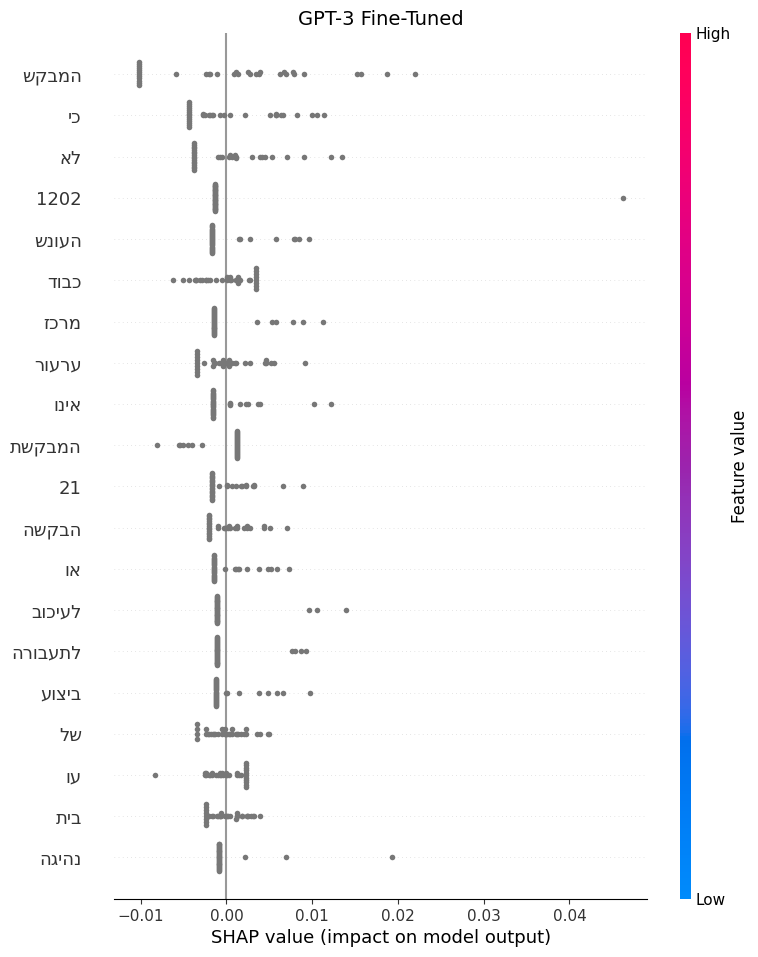

מודל: GPT-3 Fine-Tuned
------------------------------------------------------------
חמשת הפיצ'רים המשפיעים ביותר:
1. המבקש - השפעה ממוצעת: 0.0078
2. כי - השפעה ממוצעת: 0.0045
3. לא - השפעה ממוצעת: 0.0038
4. 2021 - השפעה ממוצעת: 0.0026
5. העונש - השפעה ממוצעת: 0.0026


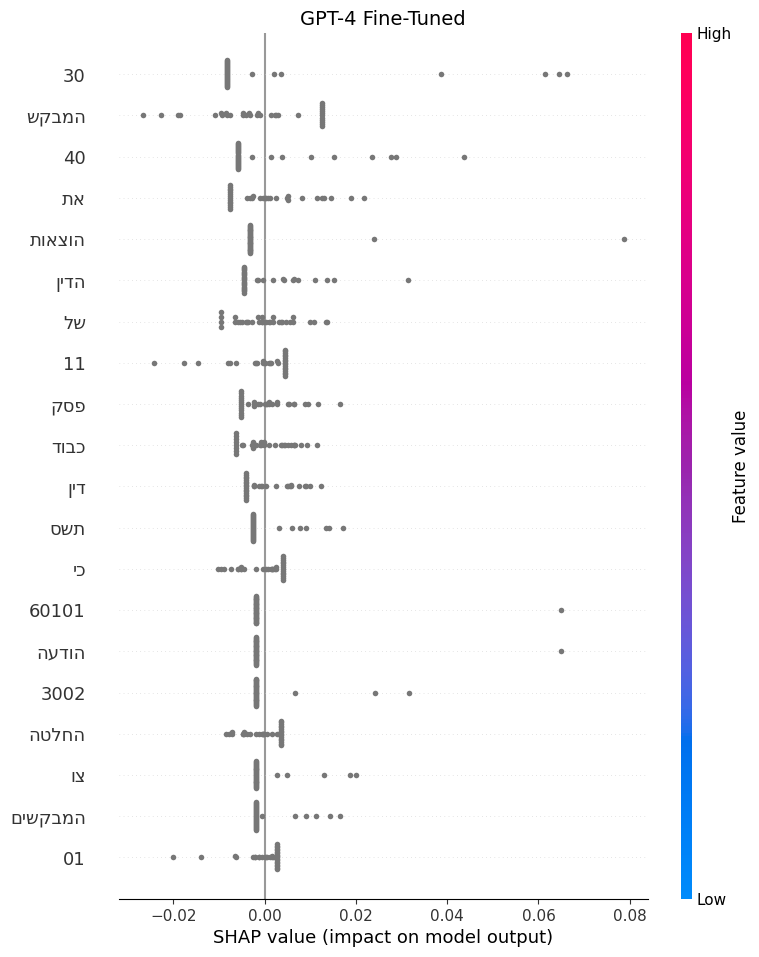

מודל: GPT-4 Fine-Tuned
------------------------------------------------------------
חמשת הפיצ'רים המשפיעים ביותר:
1. 03 - השפעה ממוצעת: 0.0135
2. המבקש - השפעה ממוצעת: 0.0095
3. 04 - השפעה ממוצעת: 0.0088
4. את - השפעה ממוצעת: 0.0069
5. הוצאות - השפעה ממוצעת: 0.0059


In [924]:
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# הכנת משתני הקלט
X_text = test_df["גוף המסמך חתוך"].astype(str)  # טקסט מקורי

# הפיכת תשובות המודלים ליעד חיזוי (מה שהמודלים חזו)
def map_model_predictions(pred):
    if "התקבל" in pred or "חלקי" in pred:
        return 1
    return 0

# יצירת מטרות חיזוי לפי מה שהמודלים חזו
y_target_gpt3 = test_df["gpt_3_res"].apply(map_model_predictions)
y_target_gpt4 = test_df["gpt_4_res"].apply(map_model_predictions)

# המרת טקסט לפיצ'רים מבוססי TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# מילון לאחסון תוצאות SHAP
shap_results = {}

# מעבר על שני המודלים וביצוע SHAP לכל אחד
for model_name, (model, y_target) in [
    ("GPT-3 Fine-Tuned", (gpt_3, y_target_gpt3)),
    ("GPT-4 Fine-Tuned", (gpt_4, y_target_gpt4))
]:

    # אימון Logistic Regression כפרוקסי למודל
    clf = LogisticRegression()
    clf.fit(X_tfidf, y_target)

    # יצירת Explainer של SHAP
    explainer = shap.Explainer(clf, X_tfidf)
    shap_values = explainer(X_tfidf)

    # שמירת התוצאות במילון
    shap_results[model_name] = shap_values

    # יצירת גרף SHAP מסכם
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, feature_names=[w[::-1] for w in vectorizer.get_feature_names_out()], show=False)

    # כותרת בעברית מודפסת בהיפוך לצורך הצגת טקסט נכון
    plt.title(f"{model_name}", fontsize=14)
    plt.show()

    print("=" * 60)
    print(f"מודל: {model_name}")
    print("-" * 60)
    print("חמשת הפיצ'רים המשפיעים ביותר:")

    # הצגת חמשת הפיצ'רים המשפיעים ביותר
    top_features = np.argsort(np.abs(shap_values.values).mean(axis=0))[-5:][::-1]
    for i, feature_idx in enumerate(top_features, 1):
        feature_name = vectorizer.get_feature_names_out()[feature_idx]  # לא הופכים עברית בהדפסה הרגילה
        avg_impact = np.abs(shap_values.values[:, feature_idx]).mean()
        print(f"{i}. {feature_name} - השפעה ממוצעת: {avg_impact:.4f}")

    print("=" * 60)


In [925]:
import lime
import lime.lime_text
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# הכנת נתוני הטקסט
X_text = test_df["גוף המסמך חתוך"].astype(str)  # טקסט מקורי

# הפיכת תשובות המודלים ליעד חיזוי
def map_model_predictions(pred):
    if "התקבל" in pred or "חלקי" in pred:
        return 1
    return 0

# יצירת מטרות חיזוי לפי מה שהמודלים חזו
y_target_gpt3 = test_df["gpt_3_res"].apply(map_model_predictions)
y_target_gpt4 = test_df["gpt_4_res"].apply(map_model_predictions)

# המרת טקסט לפיצ'רים מבוססי TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# מילון לאחסון תוצאות LIME
lime_results = {}

# מעבר על שני המודלים וביצוע LIME לכל אחד
for model_name, (model, y_target) in [
    ("GPT-3 Fine-Tuned", (gpt_3, y_target_gpt3)),
    ("GPT-4 Fine-Tuned", (gpt_4, y_target_gpt4))
]:

    # אימון Logistic Regression כפרוקסי למודל
    clf = LogisticRegression()
    clf.fit(X_tfidf, y_target)

    # יצירת Explainer של LIME
    explainer = lime.lime_text.LimeTextExplainer(class_names=["Rejected", "Accepted"])

    # בחירת פסק דין אקראי לבדיקה
    idx = np.random.randint(0, len(X_text))
    text_sample = X_text.iloc[idx]

    # פונקציה לחיזוי הסתברויות על טקסטים
    def predict_proba(texts):
        tfidf_texts = vectorizer.transform(texts)
        return clf.predict_proba(tfidf_texts)

    # יצירת ההסבר של LIME
    exp = explainer.explain_instance(
        text_sample,
        predict_proba,
        num_features=10  # הצגת 10 המילים הכי משפיעות
    )

    # שמירת התוצאה
    lime_results[model_name] = exp

    # הצגת ההסבר
    print("=" * 60)
    print(f"מודל: {model_name}")
    print("-" * 60)
    print(f"פסק דין נבחר (ID: {idx}):\n{text_sample[:500]} ...")  # הצגת 500 תווים ראשונים בלבד

    # הצגת 3 הפיצ'רים המשפיעים ביותר
    top_features = exp.as_list()[:3]
    print("\n📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:")
    for i, (word, impact) in enumerate(top_features, 1):
        print(f"{i}. '{word}' - השפעה: {impact:.4f}")

    print("=" * 60)

    # הצגת גרף LIME
    exp.show_in_notebook()


מודל: GPT-3 Fine-Tuned
------------------------------------------------------------
פסק דין נבחר (ID: 11):
['החלטה בתיק רע"פ 271/16 בבית המשפט העליון רע"פ 271/16 - א\' לפני: כבוד השופט א\' שהם המבקשת: ילנה שפיר נגד המשיבה: מדינת ישראל בקשה לעיון חוזר בשם המבקשת: עו"ד עופר חורש החלטה כפי שקבעתי בהחלטתי, מיום 17.1.2016, משלא העלתה המבקשת, עם ראשיתו של ההליך, כל השגה הנוגעת לתקינות בדיקת הינשוף שנערכה לה, לא היתה כל סיבה לזמן את עורכי התע"צ לעדות, כמו גם לרשום אותם כעדיה של המשיבה בכתב האישום. הבקשה נדחית. ניתנה היום, \u200fא\' באדר א התשע"ו (\u200f10.2.2016). ש ו פ ט _________________________  ...

📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:
1. 'המבקשת' - השפעה: -0.0003
2. 'המשיבה' - השפעה: -0.0002
3. 'כבוד' - השפעה: -0.0001


מודל: GPT-4 Fine-Tuned
------------------------------------------------------------
פסק דין נבחר (ID: 8):
['החלטה בתיק רע"פ 8223/11 בבית המשפט העליון רע"פ 8223/11 בפני: כבוד השופט א\' רובינשטיין המבקש: משה עזרן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11 בשם המבקש: עו"ד ארז רופא החלטה א. בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11, בו נדחה ערעור המבקש על פסק דינו של בית המשפט לתעבורה ברמלה (השופטת כהן) מיום 26.5.11 בתיק ת"ד 35350-07. ב. המבקש הורשע,  ...

📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:
1. '11' - השפעה: -0.0034
2. 'המבקש' - השפעה: -0.0030
3. 'כי' - השפעה: -0.0015
